In [1]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x) #  We use Flatten() to change the 3D ouputs to 1D so we can connect it to a Dense layer!
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

2022-06-20 17:26:39.712350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 17:26:40.287286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 17:26:40.287806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 17:26:40.293762: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

In [2]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

Epoch 1/5


2022-06-20 17:26:57.131148: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-06-20 17:27:08.750812: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-06-20 17:27:08.756116: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-06-20 17:27:08.756202: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-06-20 17:27:08.763798: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

938/938 [==============================] - 30s 5ms/step - loss: 0.1483 - accuracy: 0.9540
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0442 - accuracy: 0.9863
Epoch 3/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0305 - accuracy: 0.9910
Epoch 4/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0238 - accuracy: 0.9929
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0272 - accuracy: 0.9916
Test accuracy: 0.992


This model achieves around a 60% relative improvement compared to what the densely connected model from chapter 2 achieved! Not bad! Dense layers learn global patterns in their input feature space, whereas convolution layers learn local patterns - in the case of images, patterns found in the small 2D kernal windows!
Convnets are translation invariant! They can learn spatial hierarchies of patterns!
Convolutions operate over rank-3 tensors called feature maps, with two spatial axis (height and width) as well as a depth axis (channels), producing an output feature map which is also rank-3! The output depth is a parameter of the layer, we call this the number of filters! Each filter could encode a specific aspect of the input data, e.g. a filter could encode the concept of the presense of the face in the input. 
For example, the first convolution layer takes a feature map of size (28, 28, 1) and outputs a feature map of size (26, 26, 32): it computes 32 filters over its input. Each of these 32 output channels contains a 26x26 grid of values which is kown as the response map of the filter over the input. This is what the term feature map means, every dimension in the depth axis is a feature (or filter)! 

Convolutions are defined by two key parameters: Size of the patches extracted from the features; and depth of the output feature map (number of filters computed by the convolution!). 

The output width and height may differ from the input width and height for two reasons: border effects (countered by padding!) and the use of strides.

Padding can be performed in keras automatically by passing the padding argument to the Conv2D layer (padding="valid" means no padding, only valid window locations. padding="same" means use padding, pad in such a way that the output dimensions are the same as the input dimensions). By default, padding="valid"

There is also another feature called strided convolutions! Instead of moving one place over to the next window, using striding this can be set as a parameter! e.g. moving two windows means a stride of 2! A stride of 2 means the width and heigth of the feature map are downsampled by a factor of 2. There is also another more common way to downsample, max-pooling!

Max pooling consists of extracting windows from the feature maps and outputting the max value of each channel. This is usually done with 2x2 windows and stride 2, which downsamples by a factor of 2! But why would we want to downsample our models?

In [5]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainab

This isn't conductive to learning the spatial hierarchy of features. The last convolutional layers 3x3 windows won't contain information from the full 28x28 input feature map! They kernals in the last layer will only recieve information from 7x7 grids in the initial feature map! (3x3 first layer, 5x5 second layer, 7x7 final layer!)

To calculate the number of parameters in a Conv2D layer, ((kernel_size**2) * input depth * output_depth) + output_depth in this case!
There are over half a million parameters in the final layer after flattening! Thats huge! This is far to large for such a small model and woud result in intense overfitting!

Downsampling our feature maps allows us to induce spatial-filter hierarchies with less coefficients! There are also other pooling options, such as average pooling, however max pooling tends to work better!

Here we will train a simple image-classification model (cats vs dogs), first a small convnet without regularisation as a baseline, then introduce some important topics!
 - data augmentation
 - feature extraction with a pretrained model
 - fine-tuning a pretrained model

In [3]:
import os, shutil, pathlib

original_dir = pathlib.Path("dogs-vs-cats/train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
        for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3)) # This model expects RGB images of size 180 x 180
x = layers.Rescaling(1./255)(inputs) # Rescale inputs to the [0,1] range by dividing them by 255
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

In [8]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [10]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="convnet_from_scratch.keras",
                                             save_best_only=True, monitor="val_loss")]
history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 21s 327ms/step - loss: 0.7155 - accuracy: 0.5175 - val_loss: 0.6882 - val_accuracy: 0.5060
Epoch 2/30
63/63 [==============================] - 20s 321ms/step - loss: 0.7178 - accuracy: 0.5700 - val_loss: 0.7173 - val_accuracy: 0.5060
Epoch 3/30
63/63 [==============================] - 21s 328ms/step - loss: 0.6725 - accuracy: 0.6100 - val_loss: 0.7147 - val_accuracy: 0.5440
Epoch 4/30
63/63 [==============================] - 20s 319ms/step - loss: 0.6494 - accuracy: 0.6460 - val_loss: 0.6471 - val_accuracy: 0.6040
Epoch 5/30
63/63 [==============================] - 20s 321ms/step - loss: 0.6111 - accuracy: 0.6770 - val_loss: 0.6122 - val_accuracy: 0.6570
Epoch 6/30
63/63 [==============================] - 20s 324ms/step - loss: 0.5715 - accuracy: 0.7035 - val_loss: 0.6285 - val_accuracy: 0.6520
Epoch 7/30
63/63 [==============================] - 20s 316ms/step - loss: 0.5399 - accuracy: 0.7285 - val_loss: 0.6170 - val_accuracy: 0.6770

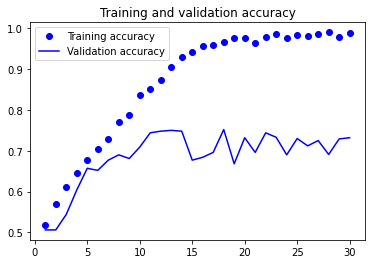

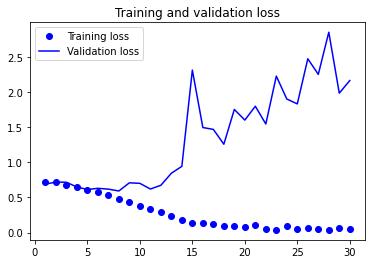

In [11]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


This is characteristic of overfitting! Lets check the test accuracy from the model in the saved file!

In [16]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 59ms/step - loss: 0.5992 - accuracy: 0.6780
Test accuracy: 0.678


We have used dropout and L2 regularisation to fight overfitting before, lets now use data augmentation! 

In [17]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

# There are plenty of other layers available for data augmentation! Check documentation!

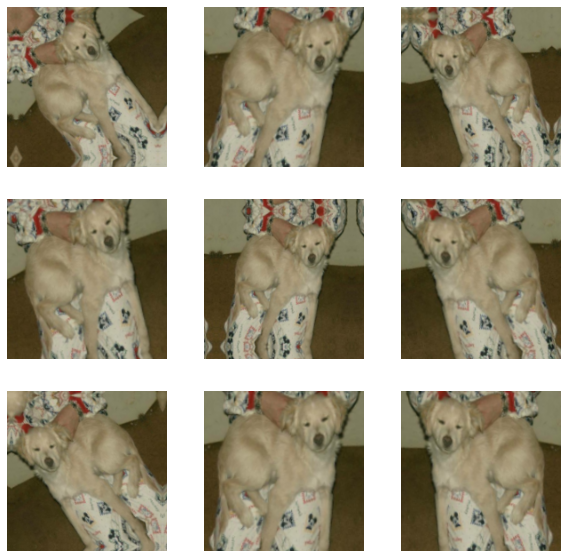

In [19]:
plt.figure(figsize=(10,10))
for image, _ in train_dataset.take(1): # We can use the take(N) method to sample N batches from the dataset!
    for i in range(9):
        augmented_image = data_augmentation(image) # Apply the data augmentation to an image!
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")

In [21]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch_with_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 21s 332ms/step - loss: 0.7018 - accuracy: 0.5315 - val_loss: 0.6851 - val_accuracy: 0.6040
Epoch 2/100
63/63 [==============================] - 21s 332ms/step - loss: 0.7167 - accuracy: 0.5350 - val_loss: 0.6769 - val_accuracy: 0.5110
Epoch 3/100
63/63 [==============================] - 21s 334ms/step - loss: 0.6736 - accuracy: 0.6000 - val_loss: 0.7222 - val_accuracy: 0.5390
Epoch 4/100
63/63 [==============================] - 21s 334ms/step - loss: 0.6516 - accuracy: 0.6310 - val_loss: 0.6678 - val_accuracy: 0.6110
Epoch 5/100
63/63 [==============================] - 21s 329ms/step - loss: 0.6544 - accuracy: 0.6350 - val_loss: 0.7229 - val_accuracy: 0.5600
Epoch 6/100
63/63 [==============================] - 21s 333ms/step - loss: 0.6203 - accuracy: 0.6635 - val_loss: 0.6450 - val_accuracy: 0.6060
Epoch 7/100
63/63 [==============================] - 21s 328ms/step - loss: 0.6104 - accuracy: 0.6655 - val_loss: 0.6813 - val_accuracy:

KeyboardInterrupt: 

In [ ]:
test_model = keras.models.load_model(
"convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

In [23]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)
conv_base.summary()

58900480/58889256 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

Fast feature extraction without data augmentation

In [25]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_image = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_image)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

train_features.shape # (samples, 5, 5, 512)

(2000, 5, 5, 512)

In [26]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [27]:
model.compile(loss="binary_crossentropy",
            optimizer="rmsprop",
            metrics=["accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint(
                filepath="feature_extraction.keras",
                save_best_only=True,
                monitor="val_loss"
)]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks
)

Epoch 1/20
63/63 [==============================] - 1s 12ms/step - loss: 15.6464 - accuracy: 0.9235 - val_loss: 5.7232 - val_accuracy: 0.9620
Epoch 2/20
63/63 [==============================] - 2s 27ms/step - loss: 4.3893 - accuracy: 0.9705 - val_loss: 3.8119 - val_accuracy: 0.9750
Epoch 3/20
63/63 [==============================] - 1s 11ms/step - loss: 1.1204 - accuracy: 0.9900 - val_loss: 17.7339 - val_accuracy: 0.9200
Epoch 4/20
63/63 [==============================] - 1s 11ms/step - loss: 1.3652 - accuracy: 0.9860 - val_loss: 4.3116 - val_accuracy: 0.9720
Epoch 5/20
63/63 [==============================] - 2s 28ms/step - loss: 1.3874 - accuracy: 0.9905 - val_loss: 3.5787 - val_accuracy: 0.9800
Epoch 6/20
63/63 [==============================] - 1s 12ms/step - loss: 0.3645 - accuracy: 0.9950 - val_loss: 4.7005 - val_accuracy: 0.9770
Epoch 7/20
63/63 [==============================] - 1s 11ms/step - loss: 0.3565 - accuracy: 0.9945 - val_loss: 16.1705 - val_accuracy: 0.9440
Epoch 8/20

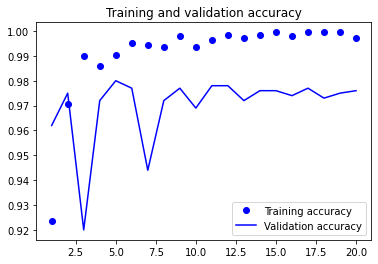

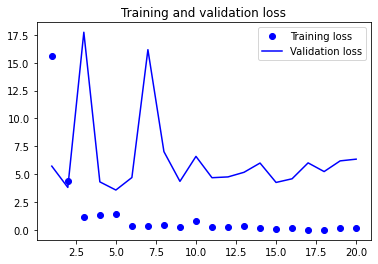

In [28]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We will now create a model that chains together the data augmentation, our frozen conv_base and a dense classifier.

In [33]:
conv_base = keras.applications.vgg16.VGG16(
weights="imagenet",
include_top=False)
conv_base.trainable = False

In [34]:
data_augmentation = keras.Sequential(
[
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
]
)
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])

In [35]:
callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="feature_extraction_with_data_augmentation.keras",
save_best_only=True,
monitor="val_loss")
]

history = model.fit(
train_dataset,
epochs=50,
validation_data=validation_dataset,
callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 64s 1s/step - loss: 21.3014 - accuracy: 0.8970 - val_loss: 4.3615 - val_accuracy: 0.9700
Epoch 2/50
63/63 [==============================] - 62s 984ms/step - loss: 6.9259 - accuracy: 0.9470 - val_loss: 4.7419 - val_accuracy: 0.9670
Epoch 3/50
63/63 [==============================] - 62s 992ms/step - loss: 5.8103 - accuracy: 0.9515 - val_loss: 5.5549 - val_accuracy: 0.9670
Epoch 4/50
63/63 [==============================] - 61s 968ms/step - loss: 4.3910 - accuracy: 0.9600 - val_loss: 5.7944 - val_accuracy: 0.9670
Epoch 5/50
63/63 [==============================] - 60s 964ms/step - loss: 3.3445 - accuracy: 0.9740 - val_loss: 7.3873 - val_accuracy: 0.9590
Epoch 6/50
63/63 [==============================] - 61s 968ms/step - loss: 5.4584 - accuracy: 0.9595 - val_loss: 5.2953 - val_accuracy: 0.9660
Epoch 7/50
63/63 [==============================] - 61s 970ms/step - loss: 3.5244 - accuracy: 0.9700 - val_loss: 5.7966 - val_accuracy: 0.9700
E

We end up with a test accuracy of ~97.5%, modest improvement compared to previous test accuracy. 

The alternative is fine tuning a pretrained model! This consists of unfreezing a few of the top layers of the frozen model:
    - add a custom network on top of the pretrained network
    - freeze the base network
    - train the part we added
    - unfreeze some layers in the base network
    - jointly train the unfrozen layers in the base network and our custom network.

To avoid diminishing returns and the risk of overfitting to a small dataset we should generally only retrain the top two or three layers of the convolutional base. 

We've already done the first free steps. Lets just use the model we already have from there!

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

We will use a very low learning rate here, this is to minimise the magnitude of modifications we make to the representations we have already!

In [ ]:
model.compile(loss="binary_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning.keras",
    save_best_only=True,
    monitor="val_loss")]
history = model.fit(train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")